In [2]:
%matplotlib inline

import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn import preprocessing
from scipy import ndimage
import scipy
import skimage
#from medpy.filter import IntensityRangeStandardization
import time, os
import shutil, pathlib
from functools import partial

In [3]:
from pathlib import Path
p=Path("data/subjects/")
file_img = list(p.rglob('*pp_t1w.nii.gz'))
file_mask = list(p.rglob('*brainmask.nii.gz'))
file_all = list(p.rglob('*.gz'))

In [4]:
def read_all_images():
    brain_list = []
    for skull_path, mask_path in list(zip(file_img, file_mask)): #gre skozi vse slike
        #make nparrays from images in file
        skull_sitk = sitk.ReadImage(str(skull_path), sitk.sitkFloat32)
        skull_array = sitk.GetArrayFromImage(skull_sitk)
        mask_sitk = sitk.ReadImage(str(mask_path), sitk.sitkFloat32)
        mask_array = sitk.GetArrayFromImage(mask_sitk)
        brain_array = skull_array * mask_array #mask just the brain
        brain_list.append(brain_array) #get a list of brain images
    return brain_list

In [5]:
brain_list = read_all_images()

In [6]:
len(brain_list)

41

In [ ]:
for i in range(len(brain_list)):
    plt.hist(brain_list[i][brain_list[i]!=0], bins = 500, histtype='step')
    plt.xlabel('Gray value')
    plt.ylabel('Number of pixles')

In [ ]:
irs = IntensityRangeStandardization(cutoffp = (1, 99), landmarkp = IntensityRangeStandardization.L4, stdrange = 'auto')

In [ ]:
brain_list_flatten = (brain.flatten() for brain in brain_list)
brain_list_without_zero = [brain[brain !=0] for brain in brain_list_flatten]

In [ ]:
irs.train(brain_list_without_zero)

In [ ]:
def standardize(image):
    idx = np.where(image != 0)
    image_tr = irs.transform(image[idx])
    new_image = np.array(image)
    new_image[idx] = image_tr
    return new_image
standardized = [standardize(brain) for brain in brain_list]

In [ ]:
for i in range(len(standardized)):
    plt.hist(standardized[i][standardized[i]!=0], bins = 500, histtype='step')
    plt.xlabel('Gray value')
    plt.ylabel('Number of pixles')

In [ ]:
def _norm(img):
    mu = np.mean(img)
    std = np.std(img)
    return (img -mu)/std

In [7]:
def mad(data, axis=None):
    return np.mean(np.absolute(data - np.mean(data, axis)), axis)
    
def norm(img: np.ndarray):
    idx = np.where(img !=0)
    mu = np.median(img[idx].flatten())
    std = mad(img[idx].flatten())
    print('.', end='')
    img_tr = (img[idx] - mu) / std   
    new_img = np.array(img)
    new_img[idx] = img_tr
    return new_img

In [8]:
normalized = [norm(brain) for brain in brain_list]
#1G

.........................................

In [29]:
np.shape(normalized[0])

(169, 214, 154)

In [61]:
[np.round(ndimage.measurements.center_of_mass(layer)) for layer in normalized]

[array([ 87., 102.,  75.]),
 array([ 82., 101.,  86.]),
 array([ 99., 109.,  79.]),
 array([ 77., 105.,  83.]),
 array([90., 92., 70.]),
 array([ 81., 102.,  76.]),
 array([ 76., 153.,  77.]),
 array([103., 130.,  83.]),
 array([118., 105.,  75.]),
 array([81., 99., 77.]),
 array([97., 97., 77.]),
 array([-50.,  14.,  10.]),
 array([85., 98., 76.]),
 array([91., 98., 75.]),
 array([56., 86., 82.]),
 array([97., 99., 83.]),
 array([ 79., 104.,  75.]),
 array([90., 92., 76.]),
 array([94., 91., 73.]),
 array([133.,  71.,  72.]),
 array([117., 114.,  77.]),
 array([ 50., 257.,  82.]),
 array([112., 107.,  77.]),
 array([84., 79., 73.]),
 array([101., 106.,  77.]),
 array([84., 96., 79.]),
 array([81., 79., 79.]),
 array([110.,  98.,  92.]),
 array([84., 97., 76.]),
 array([58., 70., 74.]),
 array([106., 109.,  78.]),
 array([90., 94., 79.]),
 array([ 88., 101.,  78.]),
 array([93., 95., 80.]),
 array([87., 96., 75.]),
 array([600., 410., 120.]),
 array([ 82., 102.,  73.]),
 array([246., 1

In [37]:
def select_layers(image):
    return [image[i, :,:] for i in range(90, 110, 2)]

In [38]:
def crop(layer,w=88,h=72):    
    center = np.round(ndimage.measurements.center_of_mass(layer))
    result = layer[np.int(center[0]) - w : np.int(center[0]) + w, np.int(center[1]) - h : np.int(center[1]) + h]
    print((np.shape(layer)), 'center:', center, 'result:', np.shape(result))
#    if (np.shape(result)) == (w*2, h*2):
#        plt.imshow(layer, cmap='gray')
#        plt.show()
#        print((np.shape(layer)), 'center:', center, 'result:', np.shape(result))
    #assert np.shape(result) == (w*2, h*2), 'pad the image more, need a bigger img'
    return result

In [39]:
layers = [select_layers(img) for img in normalized]

In [53]:
np.concatenate(layers)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [54]:
i=0

In [60]:
print(np.shape(layers[i]))
i+=1

(10, 215, 154)


In [35]:
crop = [crop(img) for img in layers]

AttributeError: 'generator' object has no attribute 'size'

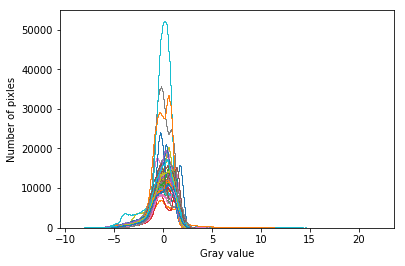

In [9]:
for i in range(len(normalized)):
    plt.hist(normalized[i][normalized[i]!=0], bins = 500, histtype='step')
    plt.xlabel('Gray value')
    plt.ylabel('Number of pixles')

In [ ]:
standardized_normalized = [norm(brain) for brain in standardized]

In [ ]:
for i in range(len(standardized_normalized)):
    plt.hist(standardized_normalized[i][standardized_normalized[i]!=0], bins = 500, histtype='step')

In [ ]:
normalized_standardize = [standardize(brain) for brain in normalized]

In [ ]:
for i in range(len(normalized_standardize)):
    plt.hist(normalized_standardize[i][normalized_standardize[i]!=0], bins = 500, histtype='step')

In [ ]:
def _change_range(img):
    img_max = img.max()
    img_min = img.min()
    norm_img = ((img - img_min)/(img_max - img_min))#*2 - 1
    return norm_img

In [ ]:
def change_range(image): ###good!!
    idx = np.where(image != 0)
    img_max = np.max(image[idx])
    img_min = np.min(image[idx])
    image_tr = ((image[idx] - img_min)/(img_max - img_min))
    new_image = np.array(image)
    new_image[idx] = image_tr
    return new_image

In [ ]:
change_range_list = [change_range(brain) for brain in brain_list]

In [ ]:
for i in range(len(change_range_list)):
    plt.hist(change_range_list[i][change_range_list[i] != 0], bins = 500, histtype='step')
    plt.xlabel('Gray value')
    plt.ylabel('Number of pixles')

In [ ]:
standardize_change_range = [change_range(brain) for brain in standardized]

In [ ]:
for i in range(len(standardize_change_range)):
    plt.hist(standardize_change_range[i][standardize_change_range[i] != 0], bins = 500, histtype='step')
    plt.xlabel('Gray value')
    plt.ylabel('Number of pixles')

In [ ]:
normalized_change_range = [change_range(brain) for brain in normalized]

In [ ]:
for i in range(len(normalized_change_range)):
    plt.hist(normalized_change_range[i][normalized_change_range[i] != 0], bins = 500, histtype='step')
    plt.xlabel('Gray value')
    plt.ylabel('Number of pixles')

In [ ]:
normalized_standardize_change_range = [change_range(brain) for brain in normalized_standardize]

In [ ]:
for i in range(len(normalized_standardize_change_range)):
    plt.hist(normalized_standardize_change_range[i][normalized_standardize_change_range[i] != 0], bins = 500, histtype='step')
    plt.xlabel('Gray value')
    plt.ylabel('Number of pixles')

In [ ]:
standardize_normalize_change_range = [change_range(brain) for brain in standardized_normalized]

In [ ]:
for i in range(len(standardize_normalize_change_range)):
    plt.hist(standardize_normalize_change_range[i][standardize_normalize_change_range[i] != 0], bins = 500, histtype='step')

In [ ]:
#if normalized and standarized doesn't matter on orrder

In [1]:
# Copyright (C) 2013 Oskar Maier
# 
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
# 
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
# 
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.
#
# author Oskar Maier
# version r0.1.2
# since 2013-09-04
# status Release

# build-in modules

# third-party modules
import numpy
from scipy.interpolate.interpolate import interp1d

# path changes

# own modules

# code
class IntensityRangeStandardization (object):
    r"""
    Class to standardize intensity ranges between a number of images.
    
    **Short description:**
    Often images containing similar objects or scenes have different intensity ranges
    that make it difficult to compare them manually as well as to process them
    further.
    
    IntensityRangeStandardization offers a way to transform a number of such images
    intensity ranges to a common standard intensity space without any loss of
    information using a multi-segment linear transformation model.
    
    Once learned, this model can be applied to other, formerly unseen images to map
    them to the same standard intensity space.    
            
    **Concept of similar images:**
    IntensityRangeStandardization is limited to similar images. Images containing
    different object or different compositions of objects are not suitable to be
    transformed to a common intensity space (and it would furthermore not make much
    sense).
    
    A typical application of IntensityRangeStandardization are MRI images showing the
    same body region. These often have different intensity ranges, even when acquired
    from the same patient and using the same scanner. For further processing, e.g.
    for training a classifier, they have to be mapped to a common intensity space.
    
    **Failure of the transformation:**
    The method implemented in IntensityRangeStandardization ensures that no
    information is lost i.e. a lossless transformation is performed. This can be
    assured when there exists a one-to-one mapping between the images original
    intensity values and their values mapped to the standard intensity space.
    
    But since the transformation model is trained on, and the standard intensity
    space range selected over the training images, this can not be guaranteed for all
    formerly unseen image. If they differ greatly from the training set images, a
    lossless transformation can not be assured anymore. In this case the transform()
    method will throw an InformationLossException.
    
    Should this happen, the model needs to be re-trained with the original training
    images and additionally the images which caused the failure. Since this will lead
    to a new intensity standard space, all already transformed images have to be
    processed again.
    
    **Setting the training parameters:**
    The method comes with a set of default parameters, that are suitable for most
    cases. But for some special cases, it might be better to set them on your own. Ti
    understand the working of the parameters, it is recommended to read the detailed
    method description first.
    
    **The method depends on three parameters:**
    
    cutoffp, i.e. the cut-off percentiles
        These are used to the define the intensity outliers, both during training and
        image transformation. The default values are usualy a good choice.
        (in [1]_ these are called the minimum and maximum percentile values pc1 and pc2 respectively)
    landmarkp, i.e. the landmark percentiles
        These percentiles define the landmark positions. The more supplied, the more
        exact but less general becomes the model. It is common to supply equally
        spaced percentiles between 0 and 100.
        (in [1]_ these are called the landmark locations mu_1, .., mu_l)
    strange, i.e. the standard intensity space range
        These two intensity values define roughly the standard intensity space (or
        common intensity space of the images; or even target intensity space) to
        which each images intensities are mapped. This space can be supplied, but it
        is usually recommended to let the method select it automatically during the
        training process. It is additionally possible to supply only the lower or
        upper range border and set the other to ''auto'', in which case the method
        chooses the range automatically, but not the position. 
        (in [1]_ these are called the minimum and maximum intensities on the standard scale of the IOI s1 resp. s2)
    
    
    **Details of the method:**
    In the following the method is described in some more detail. For even more
    information see [1]_.
         
    Essentially the method is based on a multi-segment linear transformation model. A
    standard intensity space (or common intensity space) is defined by an intensity
    value range ''stdrange''.
    During the training phase, the intensity values at certain cut-off percentiles of
    each image are computed and a single-segment linear mapping from them to the
    standard intensity space range limits created. Then the images intensity values
    at a number of landmark percentiles are extracted and passed to the linear
    mapping to be transfered roughly to the standard intensity space. The mean of all
    these mapped landmark intensities form the model learned.
      
    When presented with an image to transform, these images intensity values are
    extracted at the cut-off percentile as well as at the landmark percentile
    positions. This results in a number of segments. Using these and the
    corresponding standard intensity space range values and learned mean landmark
    values, a multi-segment linear transformation model is created for the image.
    This is then applied to the images intensity values to map them to the standard
    intensity space.
    
    Outliers, i.e. the images intensity values that lie outside of the cut-off
    percentiles, are treated separately. They are transformed like the first resp.
    last segmented of the transformation model. Not that this means the transformed
    images intensity values do not always lie inside the standard intensity space
    range, but are fitted as best as possible inside.
         
    Parameters
    ----------
    cutoffp : (float, float)
        Lower and upper cut-off percentiles to exclude outliers.
    landmarkp : sequence of floats
        List of percentiles serving as model landmarks, must lie
        between the cutoffp values.
    stdrange : string or (float, float)
        The range of the standard intensity space for which a
        transformation is learned; when set to 'auto, automatically
        determined from the training image upon training; it is also
        possible to fix either the upper or the lower border value and
        setting the other to 'auto'.
        
    Examples
    --------
    We have a number of similar images with varying intensity ranges. To make them
    comparable, we would like to transform them to a common intensity space. Thus we
    run:
    
        >>> from medpy.filter import IntensityRangeStandardization
        >>> irs = IntensityRangeStandardization()
        >>> trained_model, transformed_images = irs.train_transform(images)
        
    Let us assume we now obtain another, new image, that we would like to make
    comparable to the others. As long as it does not differ to much from these, we
    can simply call:
        
        >>> transformed_image = irs.transform(new_image)
        
    For many application, not all images are already available at the time of
    execution. It would therefore be good to be able to preserve a once trained
    model. The solution is to just pickle the once trained model:
    
        >>> import pickle
        >>> with open('my_trained_model.pkl', 'wb') as f:
        >>>     pickle.dump(irs, f)
            
    And load it again when required with:
    
        >>> with open('my_trained_model.pkl', 'r') as f:
        >>>     irs = pickle.load(f)
        
    References
    ----------
    .. [1] Nyul, L.G.; Udupa, J.K.; Xuan Zhang, "New variants of a method of MRI scale
       standardization," Medical Imaging, IEEE Transactions on , vol.19, no.2, pp.143-150,
       Feb. 2000
    """    
    
    # static member variables
    L2 = [50]
    """1-value landmark points model."""
    L3 = [25, 50, 75]
    """3-value landmark points model."""
    L4 = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    """9-value landmark points model."""
    
    def __init__(self, cutoffp = (1, 99), landmarkp = L4, stdrange = 'auto'):
        # check parameters
        if not IntensityRangeStandardization.is_sequence(cutoffp):
            raise ValueError('cutoffp must be a sequence')
        if not 2 == len(cutoffp):
            raise ValueError('cutoffp must be of length 2, not {}'.format(len(cutoffp)))
        if not IntensityRangeStandardization.are_numbers(cutoffp):
            raise ValueError('cutoffp elements must be numbers')
        if not IntensityRangeStandardization.are_in_interval(cutoffp, 0, 100, 'included'):
            raise ValueError('cutoffp elements must be in [0, 100]')
        if not cutoffp[1] > cutoffp[0]:
            raise ValueError('the second element of cutoffp must be larger than the first')
        
        if not IntensityRangeStandardization.is_sequence(landmarkp):
            raise ValueError('landmarkp must be a sequence')
        if not 1 <= len(landmarkp):
            raise ValueError('landmarkp must be of length >= 1, not {}'.format(len(landmarkp)))
        if not IntensityRangeStandardization.are_numbers(landmarkp):
            raise ValueError('landmarkp elements must be numbers')
        if not IntensityRangeStandardization.are_in_interval(landmarkp, 0, 100, 'included'):
            raise ValueError('landmarkp elements must be in [0, 100]')
        if not IntensityRangeStandardization.are_in_interval(landmarkp, cutoffp[0], cutoffp[1], 'excluded'):
            raise ValueError('landmarkp elements must be in between the elements of cutoffp')
        if not len(landmarkp) == len(numpy.unique(landmarkp)):
            raise ValueError('landmarkp elements must be unique')
        
        if 'auto' == stdrange:
            stdrange = ('auto', 'auto')
        else:
            if not IntensityRangeStandardization.is_sequence(stdrange):
                raise ValueError('stdrange must be a sequence or \'auto\'')
            if not 2 == len(stdrange):
                raise ValueError('stdrange must be of length 2, not {}'.format(len(stdrange)))
            if not 'auto' in stdrange:
                if not IntensityRangeStandardization.are_numbers(stdrange):
                    raise ValueError('stdrange elements must be numbers or \'auto\'')
                if not stdrange[1] > stdrange[0]:
                    raise ValueError('the second element of stdrange must be larger than the first')
            elif 'auto' == stdrange[0] and not IntensityRangeStandardization.is_number(stdrange[1]):
                raise ValueError('stdrange elements must be numbers or \'auto\'')
            elif 'auto' == stdrange[1] and not IntensityRangeStandardization.is_number(stdrange[0]):
                raise ValueError('stdrange elements must be numbers or \'auto\'')
                
        
        # process parameters
        self.__cutoffp = IntensityRangeStandardization.to_float(cutoffp)
        self.__landmarkp = IntensityRangeStandardization.to_float(sorted(landmarkp))
        self.__stdrange = ['auto' if 'auto' == x else float(x) for x in stdrange]
            
        # initialize remaining instance parameters
        self.__model = None
        self.__sc_umins = None
        self.__sc_umaxs = None
        
    def train(self, images):
        r"""
        Train a standard intensity space and an associated transformation model.
        
        Note that the passed images should be masked to contain only the foreground.
        
        Parameters
        ----------
        images : sequence of array_likes
            A number of images.
        
        Returns
        -------
        IntensityRangeStandardization : IntensityRangeStandardization
            This instance of IntensityRangeStandardization
        """
        self.__stdrange = self.__compute_stdrange(images)
        
        lim = []
        for idx, i in enumerate(images):
            ci = numpy.array(numpy.percentile(i, self.__cutoffp))
            li = numpy.array(numpy.percentile(i, self.__landmarkp))
            ipf = interp1d(ci, self.__stdrange)
            lim.append(ipf(li))

            # treat single intensity accumulation error            
            if not len(numpy.unique(numpy.concatenate((ci, li)))) == len(ci) + len(li):
                raise SingleIntensityAccumulationError('Image no.{} shows an unusual single-intensity accumulation that leads to a situation where two percentile values are equal. This situation is usually caused, when the background has not been removed from the image. Another possibility would be to reduce the number of landmark percentiles landmarkp or to change their distribution.'.format(idx))
            
        self.__model = [self.__stdrange[0]] + list(numpy.mean(lim, 0)) + [self.__stdrange[1]]
        self.__sc_umins = [self.__stdrange[0]] + list(numpy.min(lim, 0)) + [self.__stdrange[1]]
        self.__sc_umaxs = [self.__stdrange[0]] + list(numpy.max(lim, 0)) + [self.__stdrange[1]]
            
        return self
        
    def transform(self, image, surpress_mapping_check = False):
        r"""
        Transform an images intensity values to the learned standard intensity space.
        
        Note that the passed image should be masked to contain only the foreground.
        
        The transformation is guaranteed to be lossless i.e. a one-to-one mapping between
        old and new intensity values exists. In cases where this does not hold, an error
        is thrown. This can be suppressed by setting ``surpress_mapping_check`` to 'True'.
        Do this only if you know what you are doing.
        
        Parameters
        ----------
        image : array_like
            The image to transform.
        surpress_mapping_check : bool
            Whether to ensure a lossless transformation or not.
        
        Returns
        -------
        image : ndarray
            The transformed image
        
        Raises
        -------
        InformationLossException 
            If a lossless transformation can not be ensured
        Exception
            If no model has been trained before
        """
        if None == self.__model:
            raise UntrainedException('Model not trained. Call train() first.')
        
        image = numpy.asarray(image)
        
        # determine image intensity values at cut-off percentiles & landmark percentiles
        li = numpy.percentile(image, [self.__cutoffp[0]] + self.__landmarkp + [self.__cutoffp[1]])
        
        # treat single intensity accumulation error            
        if not len(numpy.unique(li)) == len(li):
            raise SingleIntensityAccumulationError('The image shows an unusual single-intensity accumulation that leads to a situation where two percentile values are equal. This situation is usually caused, when the background has not been removed from the image. The only other possibility would be to re-train the model with a reduced number of landmark percentiles landmarkp or a changed distribution.')
        
        # create linear mapping models for the percentile segments to the learned standard intensity space  
        ipf = interp1d(li, self.__model, bounds_error = False)
        
        # transform the input image intensity values
        output = ipf(image)
        
        # treat image intensity values outside of the cut-off percentiles range separately
        llm = IntensityRangeStandardization.linear_model(li[:2], self.__model[:2])
        rlm = IntensityRangeStandardization.linear_model(li[-2:], self.__model[-2:])
        
        output[image < li[0]] = llm(image[image < li[0]])
        output[image > li[-1]] = rlm(image[image > li[-1]])
        
        if not surpress_mapping_check and not self.__check_mapping(li):
            raise InformationLossException('Image can not be transformed to the learned standard intensity space without loss of information. Please re-train.')
        
        return output
    
    def train_transform(self, images, surpress_mapping_check = False):
        r"""
        See also
        --------
        train, transform
        """
        ret = self.train(images)
        outputs = [self.transform(i, surpress_mapping_check) for i in images]
        return ret, outputs
    
    @property
    def stdrange(self):
        """Get the set resp. learned standard intensity range."""
        return self.__stdrange
    
    @property
    def cutoffp(self):
        """Get the cut-off percentiles."""
        return self.__cutoffp
    
    @property
    def landmarkp(self):
        """Get the landmark percentiles."""
        return self.__landmarkp
    
    @property
    def model(self):
        """Get the model (the learned percentile values)."""
        return self.__model
    
    def __compute_stdrange(self, images):
        r"""
        Computes a common standard intensity range over a number of images.
        
        Depending on the settings of the internal self.__stdrange variable,
        either (1) the already fixed values are returned, (2) a complete standard
        intensity range is computed from the supplied images, (3) an intensity range
        fixed at the lower end or (4) an intensity range fixed at the upper end is
        returned.
        
        Takes into account the maximum length of each percentile segment over all
        images, then adds a security margin defined by the highest variability among
        all segments over all images.
        
        Be
        
        .. math::
        
            L = (cop_l, lp_1, lp_2, ..., lp_n, cop_u)
        
        the set formed by the two cut-off percentiles :math:`cop_l` and :math:`cop_u` and the
        landmark percentiles :math:`lp_1, ..., lp_n`. The corresponding intensity values of
        an image :math:`i\in I` are then
        
        .. math::
            
            V_i = (v_{i,1}, v_{i,2}, ..., v_{i,n+2})
        
        The distance between each of these intensity values forms a segment along the
        images :math:`i` intensity range denoted as
        
        ..math ::
            
            S_i = (s_{i,1}, s_{i,2}, ..., s_{i, n+1})
        
        The common standard intensity range :math:`sir` over the set of images :math:`I` is
        then defined as
        
        ..math ::
            sir = \sum_{l=1}^{n+1}\max_{i=1}^I s_{i,l} * \max_{l=1}^{n+1} \left(\frac{\max_{i=1}^I s_{i,l}}{\min_{i=1}^I s_{i,l}}\right)
        
        Parameters
        ----------
        images : sequence of array_like
            A number of images.
            
        Returns
        -------
        stdrange : (float, float)
            The borders of the computed standard intensity range.
        """
        if not 'auto' in self.__stdrange:
            return self.__stdrange
        
        copl, copu = self.__cutoffp
        
        # collect cutoff + landmark percentile segments and image mean intensity values 
        s = []
        m = []
        for idx, i in enumerate(images):
            li = numpy.percentile(i, [copl] + self.__landmarkp + [copu])
            
            s.append(numpy.asarray(li)[1:] - numpy.asarray(li)[:-1])
            m.append(i.mean())
            
            # treat single intensity accumulation error
            if 0 in s[-1]:
                raise SingleIntensityAccumulationError('Image no.{} shows an unusual single-intensity accumulation that leads to a situation where two percentile values are equal. This situation is usually caused, when the background has not been removed from the image. Another possibility would be to reduce the number of landmark percentiles landmarkp or to change their distribution.'.format(idx))
            
        # select the maximum and minimum of each percentile segment over all images
        maxs = numpy.max(s, 0)
        mins = numpy.min(s, 0)
        
        # divide them pairwise
        divs = numpy.divide(numpy.asarray(maxs, dtype=numpy.float), mins) 
        
        # compute interval range according to generalized theorem 2 of [1]
        intv = numpy.sum(maxs) + numpy.max(divs)
        
        # compute mean intensity value over all images (assuming equal size)
        im = numpy.mean(m)
        
        # return interval with borders according to settings
        if 'auto' == self.__stdrange[0] and 'auto' == self.__stdrange[1]:
            return im - intv / 2, im + intv / 2
        elif 'auto' == self.__stdrange[0]:
            return self.__stdrange[1] - intv, self.__stdrange[1]
        else:
            return self.__stdrange[0], self.__stdrange[0] + intv
        
    def __check_mapping(self, landmarks):
        """
        Checks whether the image, from which the supplied landmarks were extracted, can
        be transformed to the learned standard intensity space without loss of
        information.
        """
        sc_udiff = numpy.asarray(self.__sc_umaxs)[1:] - numpy.asarray(self.__sc_umins)[:-1]
        l_diff = numpy.asarray(landmarks)[1:] - numpy.asarray(landmarks)[:-1]
        return numpy.all(sc_udiff > numpy.asarray(l_diff))
        
    @staticmethod
    def is_sequence(arg):
        """
        Checks via its hidden attribute whether the passed argument is a sequence (but
        excluding strings).
        
        Credits to Steve R. Hastings a.k.a steveha @ http://stackoverflow.com
        """
        return (not hasattr(arg, "strip") and
            hasattr(arg, "__getitem__") or
            hasattr(arg, "__iter__"))
        
    @staticmethod
    def is_number(arg):
        """
        Checks whether the passed argument is a valid number or not.
        """
        import numbers
        return isinstance(arg, numbers.Number)
    
    @staticmethod
    def are_numbers(arg):
        """
        Checks whether all elements in a sequence are valid numbers.
        """
        return numpy.all([IntensityRangeStandardization.is_number(x) for x in arg])
    
    @staticmethod
    def is_in_interval(n, l, r, border = 'included'):
        """
        Checks whether a number is inside the interval l, r.
        """
        if 'included' == border:
            return (n >= l) and (n <= r)
        elif 'excluded' == border:
            return (n > l) and (n < r)
        else:
            raise ValueError('borders must be either \'included\' or \'excluded\'')
        
    @staticmethod
    def are_in_interval(s, l, r, border = 'included'):
        """
        Checks whether all number in the sequence s lie inside the interval formed by
        l and r.
        """
        return numpy.all([IntensityRangeStandardization.is_in_interval(x, l, r, border) for x in s])
    
    @staticmethod
    def to_float(s):
        """
        Cast a sequences elements to float numbers.
        """
        return [float(x) for x in s]
    
    @staticmethod
    def linear_model(x, y):
        """
        Returns a linear model transformation function fitted on the two supplied points.
        y = m*x + b
        Note: Assumes that slope > 0, otherwise division through zero might occur.
        """
        x1, x2 = x
        y1, y2 = y
        m = (y2 - y1) / (x2 - x1)
        b = y1 - (m * x1)
        return lambda x: m * x + b
    
class SingleIntensityAccumulationError(Exception):
    """
    Thrown when an image shows an unusual single-intensity peaks which would obstruct
    both, training and transformation.
    """
    
class InformationLossException(Exception):
    """
    Thrown when a transformation can not be guaranteed to be lossless.
    """
    pass
    
class UntrainedException(Exception):
    """
    Thrown when a transformation is attempted before training.
    """
    pass